# ECE 276C HW3 P2
Mingwei Xu A53270271

In [1]:
import pickle
import gym
import pybulletgym.envs
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import MultivariateNormal

## Setup CUDA

In [2]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cuda
GeForce GTX 1080


## Define Network

In [3]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0] - 1   # should be 8 (TODO: bug in env showing wrong observation space?)
        self.action_space_n = env.action_space.shape[0]   # should be 2

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, self.action_space_n)

        self.sigma = nn.Parameter(torch.eye(2))     # initalize cov matrix with grad fn
#         self.sigma = nn.Parameter(torch.diag(torch.rand(2)))

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # TODO: take sigma as input
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Tanh(),
            self.l2,
            nn.Tanh(),
            self.l3,
            nn.Tanh())

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [4]:
def choose_action(policy_network, state):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :returns: list (len=2), action; tensor with grad fn, log probability
    """
    probs = policy_network.forward(state)   # mean from policy network output

    cov = torch.abs(policy_network.sigma) + 1e-3    # positive definite

    m = MultivariateNormal(probs, cov)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.tolist(), log_prob

## Question 2

In [5]:
def reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using reinforce method

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_sum = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_sum += log_prob

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                traj_discounted_return = torch.sum(torch.FloatTensor(traj_rewards).to(device) *
                                                   torch.FloatTensor([gamma ** t for t in range(1, len(traj_rewards) + 1)]).to(device))  # G(t)
                batch_loss_sum += traj_discounted_return * traj_log_prob_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_rewards = []
                traj_log_prob_sum = 0

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

In [6]:
def reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=False):
    """
    Policy gradient training using modified reinforce method with baseline

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :param enable_baseline: bool, flag to enable baseline, defaults to False
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_loss_sum = 0
        traj_rewards = []
        traj_log_prob_list = []

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                discounted_return_list = []
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(t, len(traj_rewards))]) \
                                          for t in range(len(traj_rewards))]    # TODO
                if enable_baseline:
                    # substract discounted return list by its mean
                    discounted_return_list = np.array(discounted_return_list) - np.mean(discounted_return_list)
#                 for t in range(len(traj_rewards)):
#                     print(traj_rewards)
#                     assert False
#                     discounted_return_sum = sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(len(traj_rewards))])
#                     discounted_return_list.append(discounted_return_sum)

                # sum the traj loss by loop so we do not lose tensor gradient
                traj_loss_sum = 0
                for t in range(len(traj_log_prob_list)):
                    traj_loss_sum += traj_log_prob_list[t] * discounted_return_list[t]
                batch_loss_sum += traj_loss_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_loss_sum = 0
                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter    # TODO
        if enable_baseline:
            loss = - loss
        
        print('TODO: sigma: ', policy_network.sigma)    # TODO
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [7]:
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
# env.render()
# TODO: test
state = env.reset()
print(state)

# setup network
policy_network = PolicyNetwork(env).to(device)
average_reward_list = reinforce_with_baseline(env, policy_network,batch_size=2000, num_episodes=500,
                                              lr=0.01, gamma=0.9, enable_baseline=True)

current_dir=/home/cvv5233/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet
options= 
[ 0.3928371   0.3928371  -0.68091764  0.26561381  0.5         0.
  0.08333333  0.        ]
TODO: sigma:  Parameter containing:
tensor([[1., 0.],
        [0., 1.]], device='cuda:0', requires_grad=True)
Episode [1/500] loss: 25.59, average reward: -53.58, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0100, 0.0000],
        [0.0000, 1.0100]], device='cuda:0', requires_grad=True)
Episode [2/500] loss: 21.91, average reward: -69.08, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.0199, 0.0000],
        [0.0000, 1.0200]], device='cuda:0', requires_grad=True)
Episode [3/500] loss: 20.27, average reward: -69.82, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[1.0296, 0.0000],
        [0.0000, 1.0300]], device='cuda:0', requires_grad=True)
Episode [4/500] loss: 28.32, average reward: -81.38, trajectory num: 14
TODO: sigma:  Parameter containing:
te

TODO: sigma:  Parameter containing:
tensor([[1.3979, 0.0000],
        [0.0000, 1.4019]], device='cuda:0', requires_grad=True)
Episode [42/500] loss: 36.98, average reward: -91.93, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.4078, 0.0000],
        [0.0000, 1.4118]], device='cuda:0', requires_grad=True)
Episode [43/500] loss: 27.18, average reward: -98.06, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.4174, 0.0000],
        [0.0000, 1.4216]], device='cuda:0', requires_grad=True)
Episode [44/500] loss: 43.84, average reward: -100.06, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.4273, 0.0000],
        [0.0000, 1.4313]], device='cuda:0', requires_grad=True)
Episode [45/500] loss: 38.14, average reward: -93.05, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.4374, 0.0000],
        [0.0000, 1.4409]], device='cuda:0', requires_grad=True)
Episode [46/500] loss: 35.69, average reward: -92.27, trajectory num: 15
TODO

TODO: sigma:  Parameter containing:
tensor([[1.8111, 0.0000],
        [0.0000, 1.8071]], device='cuda:0', requires_grad=True)
Episode [84/500] loss: 50.30, average reward: -103.95, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.8212, 0.0000],
        [0.0000, 1.8169]], device='cuda:0', requires_grad=True)
Episode [85/500] loss: 50.08, average reward: -102.41, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[1.8312, 0.0000],
        [0.0000, 1.8269]], device='cuda:0', requires_grad=True)
Episode [86/500] loss: 47.72, average reward: -109.44, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.8411, 0.0000],
        [0.0000, 1.8369]], device='cuda:0', requires_grad=True)
Episode [87/500] loss: 47.10, average reward: -108.64, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[1.8511, 0.0000],
        [0.0000, 1.8467]], device='cuda:0', requires_grad=True)
Episode [88/500] loss: 41.07, average reward: -104.08, trajectory num: 15


TODO: sigma:  Parameter containing:
tensor([[2.2224, 0.0000],
        [0.0000, 2.2013]], device='cuda:0', requires_grad=True)
Episode [125/500] loss: 60.22, average reward: -115.06, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[2.2325, 0.0000],
        [0.0000, 2.2113]], device='cuda:0', requires_grad=True)
Episode [126/500] loss: 47.25, average reward: -118.76, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[2.2424, 0.0000],
        [0.0000, 2.2210]], device='cuda:0', requires_grad=True)
Episode [127/500] loss: 52.68, average reward: -109.61, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[2.2523, 0.0000],
        [0.0000, 2.2306]], device='cuda:0', requires_grad=True)
Episode [128/500] loss: 51.27, average reward: -111.81, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[2.2618, 0.0000],
        [0.0000, 2.2404]], device='cuda:0', requires_grad=True)
Episode [129/500] loss: 56.37, average reward: -112.95, trajectory num

TODO: sigma:  Parameter containing:
tensor([[2.6271, 0.0000],
        [0.0000, 2.5974]], device='cuda:0', requires_grad=True)
Episode [166/500] loss: 89.40, average reward: -138.44, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[2.6378, 0.0000],
        [0.0000, 2.6074]], device='cuda:0', requires_grad=True)
Episode [167/500] loss: 64.39, average reward: -125.56, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[2.6484, 0.0000],
        [0.0000, 2.6171]], device='cuda:0', requires_grad=True)
Episode [168/500] loss: 62.46, average reward: -114.76, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[2.6589, 0.0000],
        [0.0000, 2.6267]], device='cuda:0', requires_grad=True)
Episode [169/500] loss: 69.98, average reward: -133.18, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[2.6694, 0.0000],
        [0.0000, 2.6363]], device='cuda:0', requires_grad=True)
Episode [170/500] loss: 57.52, average reward: -133.91, trajectory num

TODO: sigma:  Parameter containing:
tensor([[3.0183, 0.0000],
        [0.0000, 2.9969]], device='cuda:0', requires_grad=True)
Episode [207/500] loss: 80.99, average reward: -146.94, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[3.0274, 0.0000],
        [0.0000, 3.0070]], device='cuda:0', requires_grad=True)
Episode [208/500] loss: 83.43, average reward: -147.38, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[3.0367, 0.0000],
        [0.0000, 3.0171]], device='cuda:0', requires_grad=True)
Episode [209/500] loss: 79.92, average reward: -141.80, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[3.0460, 0.0000],
        [0.0000, 3.0272]], device='cuda:0', requires_grad=True)
Episode [210/500] loss: 71.77, average reward: -135.58, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[3.0553, 0.0000],
        [0.0000, 3.0372]], device='cuda:0', requires_grad=True)
Episode [211/500] loss: 66.55, average reward: -132.40, trajectory num

TODO: sigma:  Parameter containing:
tensor([[3.4032, 0.0000],
        [0.0000, 3.3848]], device='cuda:0', requires_grad=True)
Episode [248/500] loss: 94.92, average reward: -151.23, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[3.4127, 0.0000],
        [0.0000, 3.3947]], device='cuda:0', requires_grad=True)
Episode [249/500] loss: 95.14, average reward: -149.91, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[3.4222, 0.0000],
        [0.0000, 3.4047]], device='cuda:0', requires_grad=True)
Episode [250/500] loss: 93.42, average reward: -154.77, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[3.4320, 0.0000],
        [0.0000, 3.4145]], device='cuda:0', requires_grad=True)
Episode [251/500] loss: 91.51, average reward: -155.07, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[3.4416, 0.0000],
        [0.0000, 3.4245]], device='cuda:0', requires_grad=True)
Episode [252/500] loss: 90.38, average reward: -150.51, trajectory num

TODO: sigma:  Parameter containing:
tensor([[3.8013, 0.0000],
        [0.0000, 3.7903]], device='cuda:0', requires_grad=True)
Episode [289/500] loss: 100.68, average reward: -155.35, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[3.8107, 0.0000],
        [0.0000, 3.8002]], device='cuda:0', requires_grad=True)
Episode [290/500] loss: 99.70, average reward: -154.76, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[3.8201, 0.0000],
        [0.0000, 3.8101]], device='cuda:0', requires_grad=True)
Episode [291/500] loss: 86.60, average reward: -144.91, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[3.8295, 0.0000],
        [0.0000, 3.8197]], device='cuda:0', requires_grad=True)
Episode [292/500] loss: 108.12, average reward: -167.79, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[3.8392, 0.0000],
        [0.0000, 3.8294]], device='cuda:0', requires_grad=True)
Episode [293/500] loss: 117.31, average reward: -171.36, trajectory 

TODO: sigma:  Parameter containing:
tensor([[4.1976, 0.0000],
        [0.0000, 4.1765]], device='cuda:0', requires_grad=True)
Episode [330/500] loss: 100.13, average reward: -174.56, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[4.2070, 0.0000],
        [0.0000, 4.1858]], device='cuda:0', requires_grad=True)
Episode [331/500] loss: 107.76, average reward: -165.62, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[4.2163, 0.0000],
        [0.0000, 4.1952]], device='cuda:0', requires_grad=True)
Episode [332/500] loss: 108.81, average reward: -171.21, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[4.2257, 0.0000],
        [0.0000, 4.2046]], device='cuda:0', requires_grad=True)
Episode [333/500] loss: 103.90, average reward: -163.57, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[4.2352, 0.0000],
        [0.0000, 4.2139]], device='cuda:0', requires_grad=True)
Episode [334/500] loss: 114.63, average reward: -165.29, trajector

TODO: sigma:  Parameter containing:
tensor([[4.5854, 0.0000],
        [0.0000, 4.5723]], device='cuda:0', requires_grad=True)
Episode [371/500] loss: 123.36, average reward: -184.18, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[4.5947, 0.0000],
        [0.0000, 4.5817]], device='cuda:0', requires_grad=True)
Episode [372/500] loss: 124.77, average reward: -187.51, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[4.6042, 0.0000],
        [0.0000, 4.5911]], device='cuda:0', requires_grad=True)
Episode [373/500] loss: 111.46, average reward: -172.84, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[4.6138, 0.0000],
        [0.0000, 4.6004]], device='cuda:0', requires_grad=True)
Episode [374/500] loss: 98.80, average reward: -151.24, trajectory num: 17
TODO: sigma:  Parameter containing:
tensor([[4.6233, 0.0000],
        [0.0000, 4.6095]], device='cuda:0', requires_grad=True)
Episode [375/500] loss: 115.11, average reward: -177.63, trajectory

TODO: sigma:  Parameter containing:
tensor([[4.9790, 0.0000],
        [0.0000, 4.9678]], device='cuda:0', requires_grad=True)
Episode [412/500] loss: 113.85, average reward: -181.93, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[4.9888, 0.0000],
        [0.0000, 4.9777]], device='cuda:0', requires_grad=True)
Episode [413/500] loss: 146.50, average reward: -204.20, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[4.9989, 0.0000],
        [0.0000, 4.9876]], device='cuda:0', requires_grad=True)
Episode [414/500] loss: 120.91, average reward: -187.55, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[5.0089, 0.0000],
        [0.0000, 4.9974]], device='cuda:0', requires_grad=True)
Episode [415/500] loss: 162.69, average reward: -205.36, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[5.0192, 0.0000],
        [0.0000, 5.0073]], device='cuda:0', requires_grad=True)
Episode [416/500] loss: 140.78, average reward: -206.97, trajector

TODO: sigma:  Parameter containing:
tensor([[5.3909, 0.0000],
        [0.0000, 5.3833]], device='cuda:0', requires_grad=True)
Episode [453/500] loss: 139.27, average reward: -185.88, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[5.4010, 0.0000],
        [0.0000, 5.3935]], device='cuda:0', requires_grad=True)
Episode [454/500] loss: 135.32, average reward: -209.25, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[5.4112, 0.0000],
        [0.0000, 5.4035]], device='cuda:0', requires_grad=True)
Episode [455/500] loss: 133.67, average reward: -191.15, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[5.4214, 0.0000],
        [0.0000, 5.4133]], device='cuda:0', requires_grad=True)
Episode [456/500] loss: 156.54, average reward: -208.95, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[5.4317, 0.0000],
        [0.0000, 5.4232]], device='cuda:0', requires_grad=True)
Episode [457/500] loss: 121.59, average reward: -195.24, trajector

TODO: sigma:  Parameter containing:
tensor([[5.7949, 0.0000],
        [0.0000, 5.7788]], device='cuda:0', requires_grad=True)
Episode [494/500] loss: 117.94, average reward: -196.61, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[5.8045, 0.0000],
        [0.0000, 5.7886]], device='cuda:0', requires_grad=True)
Episode [495/500] loss: 127.76, average reward: -208.21, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[5.8141, 0.0000],
        [0.0000, 5.7982]], device='cuda:0', requires_grad=True)
Episode [496/500] loss: 135.49, average reward: -207.02, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[5.8235, 0.0000],
        [0.0000, 5.8078]], device='cuda:0', requires_grad=True)
Episode [497/500] loss: 168.54, average reward: -221.49, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[5.8331, 0.0000],
        [0.0000, 5.8176]], device='cuda:0', requires_grad=True)
Episode [498/500] loss: 151.16, average reward: -227.14, trajector

### Plot

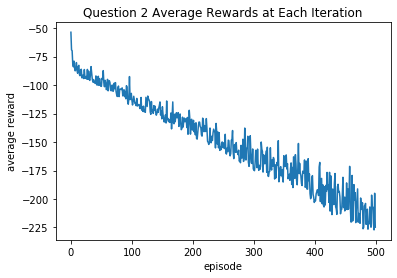

In [8]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('episode')
plt.ylabel('average reward')
plt.title('Question 2 Average Rewards at Each Iteration')
plt.savefig('Question_2.png')
plt.show()

### Save Policy

In [9]:
with open('p2_policy.pkl', 'wb') as pickle_file:
    pickle.dump(policy_network, pickle_file)

## Test Policy

In [10]:
# load policy
# with open('p2_policy.pkl', 'rb') as pickle_file:
#     policy_network = pickle.load(pickle_file)

# test policy
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
# env.render()
state = env.reset()
done = False
steps = 0

while not done:
    # TODO: do not sample here
    action, log_prob = choose_action(policy_network, state)
    state_next, reward, done, _ = env.step(action)
    steps += 1

print('Finished in {} steps'.format(steps))

options= 
Finished in 150 steps
